This notebook contains plots produced in the validation sections of the paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns 
sns.set_style('ticks')

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

import pickle
import re
import os
import copy

from tqdm import tqdm
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data


from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

class ResultsObject():
    pass

Set Theano Environmental Variables for Parallelisation


In [3]:
data = preprocess_data('../../merged_data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [4]:
results_base_dir = "../../server_neurips2"

def tag_fname_to_label(tag, fname):    
    if tag == "npi_leaveout":
        npi_names = data.CMs
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
            
        return label
        
    if tag == "oxcgrt":
        npi_names = ['Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                          'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing']
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
        return label

    if tag == "region_holdout":
        return fname[:2]
    
    if tag == "cases_threshold":
        r = re.search(r"(cases_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "deaths_threshold":
        r = re.search(r"(deaths_t)(\d*)", fname)
        return r.groups()[1]
            
#     if tag == "NPI_prior":
#         if "icl" in fname:
#             return "Flaxman et. al."
        
#         if "half_normal" in fname:
#             return "$\\alpha_i \sim$Half Normal$(0.2^2)$"
        
#         if "normal" in fname:
#             return "$\\alpha_i \sim$Normal$(0, 0.2^2)$"
        
    if tag == "oxcgrt":
        npi_names = ['Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                          'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing']
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
        return label
            
#     if tag == "R_prior":
#         r = re.search(r"(R_prior-)(\d*.\d*)", fname)
#         val = r.groups()[1]
#         return val

    if tag == "region_holdout":
        return fname[:2]
    
        
    if tag == "cases_delay":
        cd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        return cd
    
    if tag == "deaths_delay":
        dd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        return dd
    
    if tag == "generation_interval":
        gi = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        return gi
        
    return f"{tag} - {fname}"

def load_tagged_traces(result_base_dir, model_type, tag):
    path = os.path.join(results_base_dir, model_type, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and 'CasesDelay' not in f and 'DeathsDeath' not in f and '_GI_' not in f and 'divergences' not in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    all_traces.append([trace, tag_fname_to_label(tag, f)])
                except Exception as e:
                    print(e)
                    
    return all_traces

def search_tagged_traces(result_base_dir, model_type,  tag, search_key):
    path = os.path.join(results_base_dir, model_type, tag)
    
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and search_key in f:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    label =  tag_fname_to_label(tag, f)
                    return (trace, label)
    
    print('No experiment found')
    return None

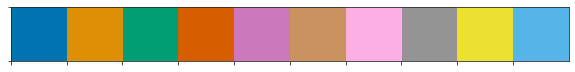

In [5]:
sns.palplot(sns.color_palette("colorblind"))

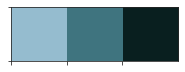

In [6]:
cols = sns.cubehelix_palette(3, start=2.4, light=0.7, dark=0.1, rot=0.1)
sns.palplot(cols)

derived_features_comb = [
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to\n1000 people or less", [1]),
 ("Gatherings limited to\n100 people or less", [2, 1]),
 ("Gatherings limited to\n10 people or less", [3, 2, 1]),
 ("Some businesses\nclosed", [4]),
 ("Most nonessential\nbusinesses closed", [5, 4]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),  
 ]

derived_features_uncomb = [
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to\n1000 people or less", [1]),
 ("Gatherings limited to\n100 people or less", [2]),
 ("Gatherings limited to\n10 people or less", [3]),
 ("Some businesses\nclosed", [4]),
 ("Most nonessential\nbusinesses closed", [5]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),  
 ]

fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

# Bar Chart for Holdouts

In [7]:
from scipy.stats import nbinom

def compute_cases_region_holdout_ll(mdir, rg, data):
    # assume data.mask_reopenings() has already been called
    
    r_i = data.Rs.index(f'{rg}')
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)

    end_d_i = len(data.Ds) if end_d_i > len(data.Ds) else end_d_i

    cases_start, deaths_start = data.mask_region(rg)
    try:   
        res = pickle.load(open(os.path.join(mdir, f"{rg}.pkl"), "rb"))
        
        ec = res.ExpectedCases[:, cases_start:end_d_i]
        nS, nDs_c = ec.shape
    
        alpha = np.repeat(res.PsiCases.reshape(nS, 1), nDs_c, axis = -1)     
        p = alpha / (alpha + ec)
        average_ll_per_day = np.log(np.mean(nbinom.pmf(data.NewCases.data[r_i, cases_start:(end_d_i)], alpha, p), axis=0))
        total_ll = np.sum(average_ll_per_day)
        return total_ll, nDs_c
    except Exception as e:
        print(e)
        return 0, 0
        
def compute_deaths_region_holdout_ll(mdir, rg, data):
    # assume data.mask_reopenings() has already been called
    r_i = data.Rs.index(f'{rg}')
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)

    end_d_i = len(data.Ds) if end_d_i > len(data.Ds) else end_d_i

    cases_start, deaths_start = data.mask_region(rg)

    try:   
        res = pickle.load(open(os.path.join(mdir, f"{rg}.pkl"), "rb"))
        ed = res.ExpectedDeaths[:, deaths_start:end_d_i]
        nS, nDs_d = ed.shape
    
        alpha = np.repeat(res.PsiDeaths.reshape(nS, 1), nDs_d, axis = -1)     
        p = alpha / (alpha + ed)
        average_ll_per_day = np.log(np.mean(nbinom.pmf(data.NewDeaths.data[r_i, deaths_start:(end_d_i)], alpha, p), axis=0))
        total_ll = np.sum(average_ll_per_day)
        
        return total_ll, nDs_d
    except Exception as e:
        print(e)
        return 0, 0

In [8]:
def compute_model_ll(model_type, base_dir='../../server_neurips2/'):
    model_path = os.path.join(base_dir, model_type)
    print(model_type)
    data.unmask_all()
    data.mask_reopenings(print_out=False)
    cases_ll = 0
    cases_days = 0
    for rg in ['DE', 'RO', 'MX', 'IT', 'AT','PT']:
        cases_r_ll, ds_r = compute_cases_region_holdout_ll(model_path, rg, data)
        cases_ll += cases_r_ll
        cases_days += ds_r
    
    data.unmask_all()
    data.mask_reopenings(print_out=False)
    deaths_ll = 0
    deaths_days = 0
    for rg in ['DE', 'RO', 'MX', 'IT', 'AT','PT']:
        deaths_r_ll, ds_r = compute_deaths_region_holdout_ll(model_path, rg, data)
        deaths_ll += deaths_r_ll
        deaths_days += ds_r
    
    return cases_ll, cases_days, deaths_ll, deaths_days

In [9]:
model_types = ['default', 'additive', 'diffeff', 'noisy_r', 'dr', 'deaths_dr', 'icl', 'default_nonoise']
model_names = ['Default', 'Additive Effects', 'Different Effects', 'Noisy-R', 'Discrete Renewal (DR)', 'Deaths-Only DR', 'Flaxman et al. [8]',  'Default\n(No Transmission Noise)']
mcols = sns.color_palette("colorblind")

cases_ave_ll = np.zeros(len(model_types))
deaths_ave_ll = np.zeros(len(model_types))

for m_i, m in tqdm(enumerate(model_types)):
    cll, cd, dll, dd = compute_model_ll(m)
    try:
        cases_ave_ll[m_i] = cll/cd
    except:
        pass
    
    try:
        deaths_ave_ll[m_i] = dll/dd
    except:
        pass

0it [00:00, ?it/s]

default


1it [00:00,  1.50it/s]

additive


2it [00:01,  1.55it/s]

diffeff


3it [00:01,  1.61it/s]

noisy_r


4it [00:02,  1.66it/s]

dr


5it [00:02,  1.65it/s]

deaths_dr
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'


6it [00:03,  1.94it/s]

icl
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'
'ResultsObject' object has no attribute 'ExpectedCases'


7it [00:03,  2.25it/s]

default_nonoise


8it [00:04,  1.95it/s]


In [10]:
def produce_score_sd(traces, derived_features, exclude=None, additive=False):
    median_values = np.zeros((0, len(derived_features)))
    labels_used = []
    
    for trace, label in traces:
        if exclude is not None:
            if isinstance(exclude, list):
                flags = [e in label for e in exclude]
                if any(flags):
                    continue
            else:
                if exclude in label:
                    continue
        
        if not additive:
            med = np.median(combine_trace(trace[:, :9], derived_features), axis=0)
        else:
            med = np.median(combine_trace_additive(trace[:, :9], derived_features), axis=0)
        labels_used.append(label)
        median_values = np.append(median_values, med.reshape((1, len(derived_features))), axis=0)
        
    med_stds = np.nanstd(median_values, axis=0)
    score = np.mean(med_stds)
    
    print(f'Produced stored using {[labels_used]}')
    return score

def combine_trace(trace, derived_features):
    nS, _ = trace.shape
    nCMs = len(derived_features)
    derived_samples = np.zeros((nS, nCMs))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * trace[:, r] 
        derived_samples[:, f_i] = samples

    res = copy.deepcopy(derived_samples)
    res = 100*(1-res)
    
    return res


def combine_trace_additive(trace, derived_features):
    nS, _ = trace.shape
    nCMs = len(derived_features)
    derived_samples = np.zeros((nS, nCMs))
    
    
    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.zeros(nS)
        for r in prodrows:
            samples = samples + trace[:, r] 
        derived_samples[:, f_i] = samples

    res = copy.deepcopy(derived_samples)
    res = 100*(res)
    
    return res

In [11]:
leaveout_scores = np.zeros(len(model_types))
addin_scores = np.zeros(len(model_types))

for m_i, m in enumerate(model_types):
    
    derived_features = derived_features_uncomb
    traces = load_tagged_traces(results_base_dir, m, "oxcgrt")
    
    additive = True if 'additive' in m else False
    
    if 'Symptomatic Testing' in [n for _, n in traces]:
        testing_index = [n for _, n in traces].index('Symptomatic Testing')
        orig = copy.deepcopy(traces[testing_index][0])
        traces[testing_index][0] = orig[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]]
    
    produce_score_sd(traces, derived_features_uncomb, additive=additive)
    
    addin_scores[m_i] = produce_score_sd(traces, derived_features_uncomb, additive=additive)
    
    derived_features = derived_features_uncomb
    traces = load_tagged_traces(results_base_dir, m, "npi_leaveout")
    
    labels = [l for _, l in traces]
    for l_i, label in enumerate(labels):
        for cm_i, cm in enumerate(data.CMs):
            if '<' not in cm and cm in label:
                traces[l_i][0][:, cm_i] = np.nan
            if cm == label:
                traces[l_i][0][:, cm_i] = np.nan
    
    leaveout_scores[m_i] = produce_score_sd(traces, derived_features_uncomb)

Produced stored using [['Public Information Campaigns', 'Symptomatic Testing', 'Internal Movement Limited', 'Public Transport Limited', 'Travel Screen/Quarantine,\nTravel Bans']]
Produced stored using [['Public Information Campaigns', 'Symptomatic Testing', 'Internal Movement Limited', 'Public Transport Limited', 'Travel Screen/Quarantine,\nTravel Bans']]
Produced stored using [['Some Businesses Suspended', 'Most Businesses Suspended', 'University Closure', 'School Closure', 'Gatherings <10', 'Gatherings <100', 'Mask Wearing', 'Stay Home Order', 'Gatherings <1000']]
Produced stored using [['Public Information Campaigns', 'Symptomatic Testing', 'Internal Movement Limited', 'Public Transport Limited', 'Travel Screen/Quarantine,\nTravel Bans']]
Produced stored using [['Public Information Campaigns', 'Symptomatic Testing', 'Internal Movement Limited', 'Public Transport Limited', 'Travel Screen/Quarantine,\nTravel Bans']]
Produced stored using [['Some Businesses Suspended', 'Most Businesses

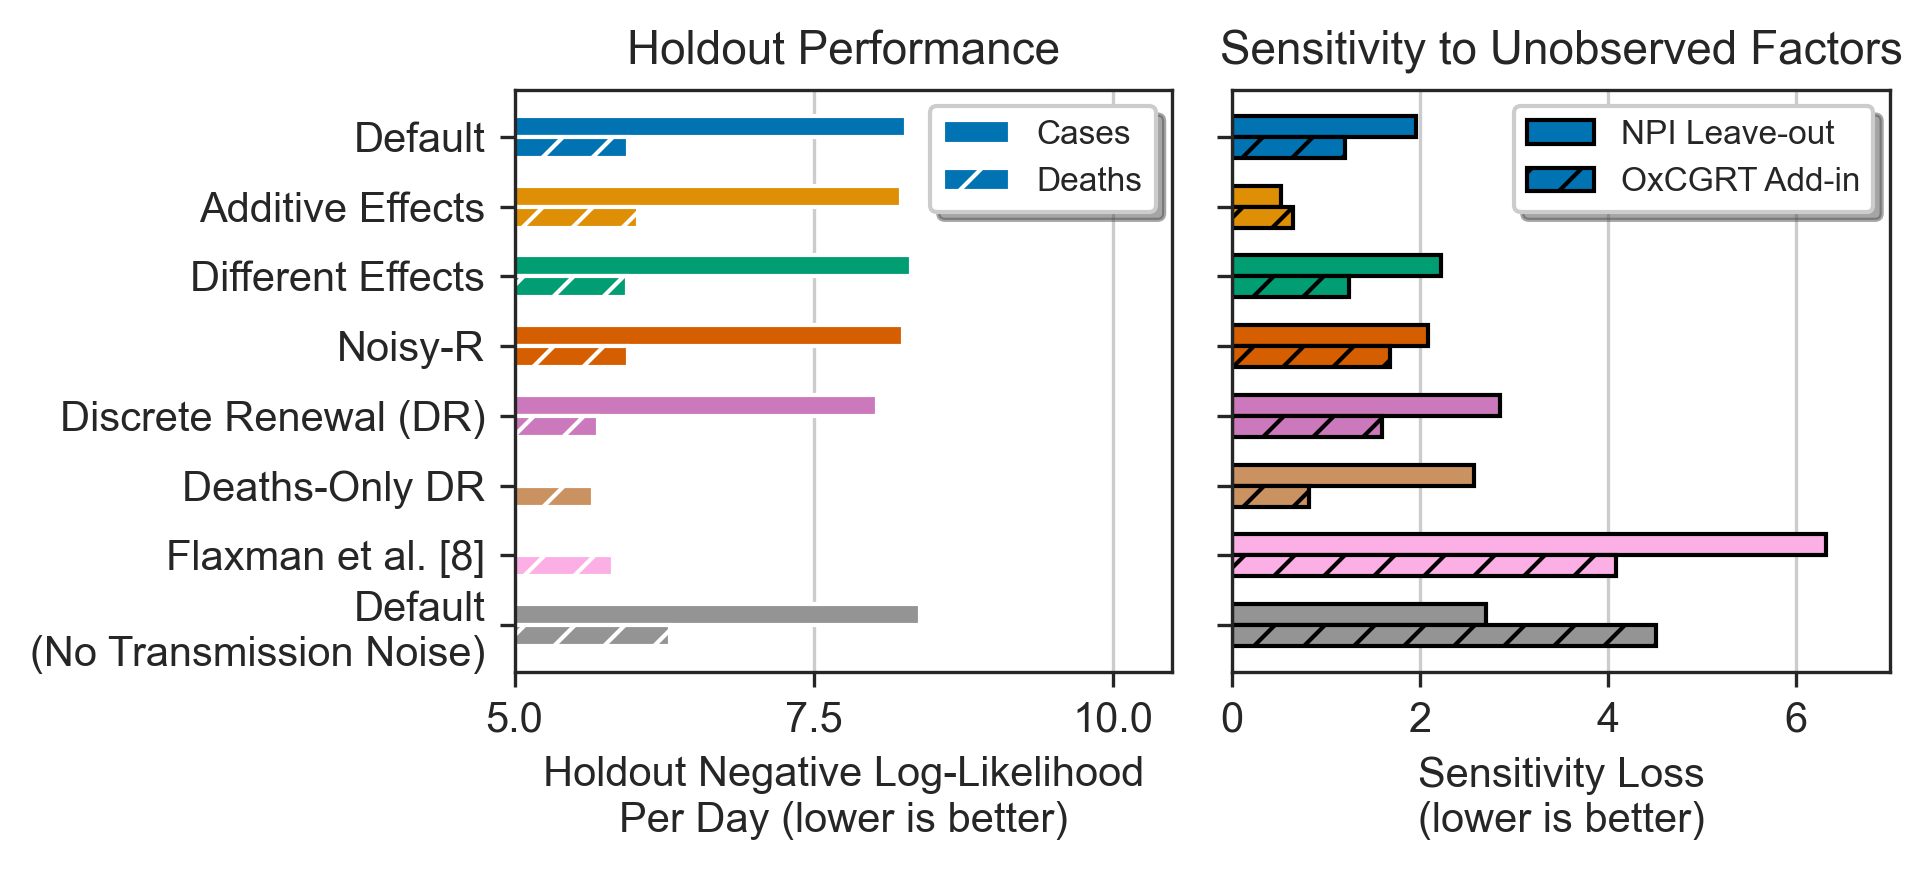

In [21]:
plt.figure(figsize=(6.5, 3), dpi=300)
plt.subplot(121)

for i in range(len(model_types)):
    if i == 0:
        plt.barh(-i+0.15, -cases_ave_ll[i], align='center', height=0.3, color=mcols[i], label='Cases')
        plt.barh(-i-0.15, -deaths_ave_ll[i], align='center', height=0.3, color=mcols[i], hatch='//', label='Deaths')
    else:
        plt.barh(-i+0.15, -cases_ave_ll[i], align='center', height=0.3, color=mcols[i])
        plt.barh(-i-0.15, -deaths_ave_ll[i], align='center', height=0.3, color=mcols[i], hatch='//')

plt.yticks(-np.arange(len(model_types)), model_names, fontsize=10, ha='right')
plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)
plt.xlabel('Holdout Negative Log-Likelihood\nPer Day (lower is better)', fontsize=10)
plt.title('Holdout Performance', fontsize=11)
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5])
plt.xlim([5, 10.5])

plt.grid(b=None, which='major', axis='x')

plt.subplot(122)

for i in range(len(model_types)):
    if i == 0:
        plt.barh(-i+0.15, leaveout_scores[i], align='center', height=0.3, color=mcols[i], label='NPI Leave-out', edgecolor='black')
        plt.barh(-i-0.15, addin_scores[i], align='center', height=0.3, color=mcols[i], hatch='//', label='OxCGRT Add-in', edgecolor='black')
    else:
        plt.barh(-i+0.15, leaveout_scores[i], align='center', height=0.3, color=mcols[i], edgecolor='black')
        plt.barh(-i-0.15, addin_scores[i], align='center', height=0.3, color=mcols[i], hatch='//', edgecolor='black')

plt.yticks(-np.arange(len(model_types)), ["" for m in model_types], fontsize=10, ha='right')
plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)
plt.xlabel('Sensitivity Loss\n(lower is better)', fontsize=10)
plt.title('Sensitivity to Unobserved Factors', fontsize=11)
plt.xlim([0, 7])

plt.grid(b=None, which='major', axis='x')

plt.tight_layout()
plt.savefig('holdouts_uob.pdf', bbox_inches='tight')

# Box Plot

In [23]:
categories = ['cases_delay', 'cases_threshold', 'deaths_delay', 'deaths_threshold', 'generation_interval', 'npi_leaveout', 'oxcgrt', 'region_holdout', 'npi_prior', 'R_prior']

data_categories = ['cases_threshold', 'deaths_threshold', 'npi_leaveout', 'oxcgrt', 'region_holdout']
epi_categories  = ['cases_delay', 'deaths_delay', 'generation_interval', 'npi_prior', 'R_prior']

def grab_model_loaded_dict(model_type, categories):
    loaded_dict = {}
    nCMs = len(derived_features)

    for c_i, c in enumerate(categories):
        ts = load_tagged_traces(results_base_dir, model_type, c)
       
        if len(ts) > 0 :
            rts, labels = zip(*ts)

            if c == 'npi_leaveout':
                for l_i, label in enumerate(labels):
                    for cm_i, cm in enumerate(data.CMs):
                        if cm in label and '<' not in cm:
                            rts[l_i][:, cm_i] = np.nan
                        elif cm == label:
                            rts[l_i][:, cm_i] = np.nan

            if c == 'oxcgrt':
                for l_i, label in enumerate(labels):
                    if label == 'Symptomatic Testing':
                        temp = copy.deepcopy(rts[l_i])
                        rts[l_i][:, 0] = temp[:, 0]
                        rts[l_i][:, 1:9] = temp[:, 2:10]

            if c == 'scalings':
                rts = [np.exp(-t) for t in rts]

            medians = np.zeros((0, nCMs))
            
            for t in rts:
                if 'additive' in model_type:
                    comb_t = np.median(combine_trace_additive(t, derived_features), axis=0).reshape((1, nCMs))
                else:
                    comb_t = np.median(combine_trace(t, derived_features), axis=0).reshape((1, nCMs))
                medians = np.append(comb_t, medians, axis=0)

            loaded_dict[c] = medians
        else:
            loaded_dict[c] = None
        
    return loaded_dict

In [129]:
derived_features = derived_features_comb

full_data_dicts = [grab_model_loaded_dict(m, categories) for m in model_types]
model_data_dicts = [grab_model_loaded_dict(m, data_categories) for m in model_types]
model_epi_dicts = [grab_model_loaded_dict(m, epi_categories) for m in model_types]

In [37]:
import pandas as pd

def model_dict_to_score(loaded_dict):
    xs = []
    
    all_medians = np.zeros((0, 8))
    for cat in loaded_dict.keys():
        all_medians = np.append(all_medians, loaded_dict[cat], axis=0)
        
    scores = np.nanstd(all_medians, axis=0)
    
    return scores

In [170]:
def model_dict_to_median_estiamtes(loaded_dict):
    xs = []
    
    all_medians = np.zeros((0, 8))
    for cat in loaded_dict.keys():
        all_medians = np.append(all_medians, loaded_dict[cat], axis=0)
        
    return all_medians

In [38]:
model_dict_to_score(model_data_dicts[0])

array([0.44079138, 2.21632429, 2.29312509, 2.34029706, 3.02526875,
       2.88609687, 2.16033984, 1.20007176])

In [40]:
model_names[:6]

['Default',
 'Additive Effects',
 'Different Effects',
 'Noisy-R',
 'Discrete Renewal (DR)',
 'Deaths-Only DR']

In [47]:
all_epi_scores = np.zeros((0, 8))
all_data_scores = np.zeros((0, 8))

for data_dict, epi_dict in list(zip(model_data_dicts, model_epi_dicts)):
    epi_score = model_dict_to_score(epi_dict)
    data_score = model_dict_to_score(data_dict)
    
    all_epi_scores = np.append(all_epi_scores, np.array(epi_score).reshape((1, 8)), axis=0)
    all_data_scores = np.append(all_data_scores, np.array(data_score).reshape((1, 8)), axis=0)

In [49]:
average_epi_score = np.mean(all_epi_scores[:6, :], axis=0)
average_data_score = np.mean(all_data_scores[:6, :], axis=0)

In [50]:
average_epi_score

array([1.67012676, 7.94557935, 5.53519024, 4.30438321, 4.43759395,
       5.13909282, 4.00202755, 1.51756422])

In [57]:
data.CMs

['Mask Wearing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'University Closure',
 'Stay Home Order']

In [105]:
derived_features = [
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to\n1000 people or less", [1]),
 ("Gatherings limited to\n100 people or less", [2, 1]),
 ("Gatherings limited to\n10 people or less", [3, 2, 1]),
 ("Some businesses\nclosed", [4]),
 ("Most nonessential\nbusinesses closed", [5, 4]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),  
 ]

cm_names = [l for l, _ in derived_features]

In [184]:
medians = np.zeros((0, 8))
for m_i, model_dict in enumerate(full_data_dicts):
    if m_i in [0, 2, 3, 4, 5]:
        medians = np.append(medians, model_dict_to_median_estiamtes(model_dict), axis=0)

In [189]:
model_dict_to_median_estiamtes(edict).shape

(23, 8)

In [182]:
medians.shape

(692, 8)

In [185]:
scores = np.nanstd(medians, axis=0)

In [156]:
medians_red = medians[[0, 2, 3, 4, 5], :]

diffs = np.abs(np.max(medians_red, axis=0) - np.min(medians_red, axis=0))

In [165]:
medians_red

array([[-0.94930582, 15.86889803, 27.50458903, 35.30844879, 21.76978155,
        29.3937676 , 43.08641642,  9.3730187 ],
       [ 2.06633787, 18.73864096, 29.44861448, 34.53379322, 21.49927841,
        29.22544297, 40.66777615, 17.70949216],
       [-1.68416801, 18.32168517, 29.24351855, 36.07024641, 22.0166049 ,
        29.7747853 , 43.86536935, 10.36223513],
       [ 1.72339088,  3.44499541, 16.97572351, 42.31306508, 32.8964184 ,
        40.9927618 , 41.57962154, 11.84405698],
       [ 1.20827847,  1.09719828, 30.06014595, 52.77664924, 19.48411236,
        29.25902947, 44.03996252,  3.72253958]])

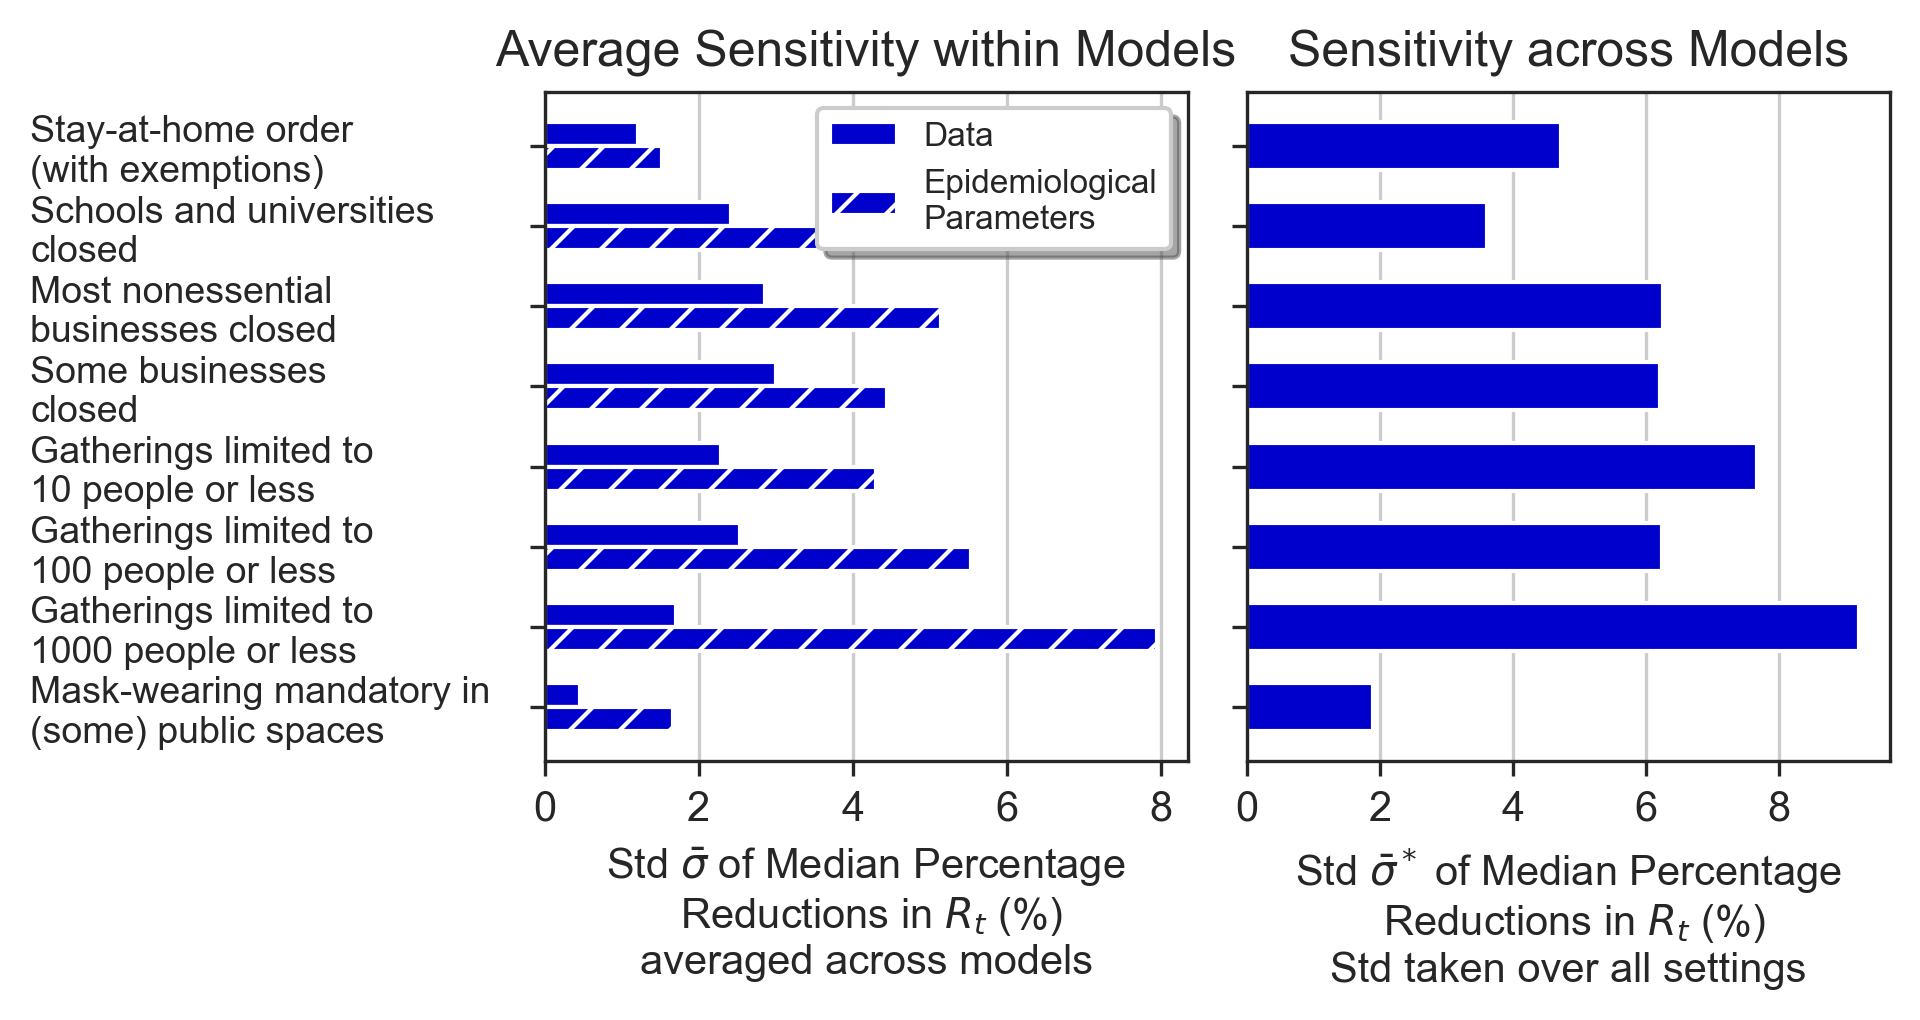

In [186]:
plt.figure(figsize=(6.5, 3.5), dpi=300)

plt.subplot(121)
for i in range(8):
    if i == 0:
        plt.barh(i+0.15, average_data_score[i], align='center', height=0.3, color='mediumblue', label='Data')
        plt.barh(i-0.15, average_epi_score[i], align='center', height=0.3, color='mediumblue', hatch='//', label='Epidemiological\nParameters')   
    else:
        plt.barh(i+0.15, average_data_score[i], align='center', height=0.3, color='mediumblue')
        plt.barh(i-0.15, average_epi_score[i], align='center', height=0.3, color='mediumblue', hatch='//')

plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)

plt.yticks(np.arange(8), cm_names, fontsize=9, ha='left')
yax = plt.gca().get_yaxis()
yax.set_tick_params(pad=120)

plt.xlabel('Std $\\bar{\\sigma}$ of Median Percentage\n Reductions in $R_t$ (%)\naveraged across models')

plt.grid(b=None, which='major', axis='x')

plt.title('Average Sensitivity within Models')

plt.subplot(122)

for i in range(8):
    plt.barh(i, scores[i], align='center', height=0.6, color='mediumblue', label='Data')

plt.xlabel('Std $\\bar{\\sigma}^*$ of Median Percentage\n Reductions in $R_t$ (%)\nStd taken over all settings')
plt.yticks(np.arange(8), ["" for i in range(8)], fontsize=9, ha='left')

plt.grid(b=None, which='major', axis='x')

plt.title('Sensitivity across Models')

plt.tight_layout()
plt.savefig('robustness.pdf', bbox_inches='tight')

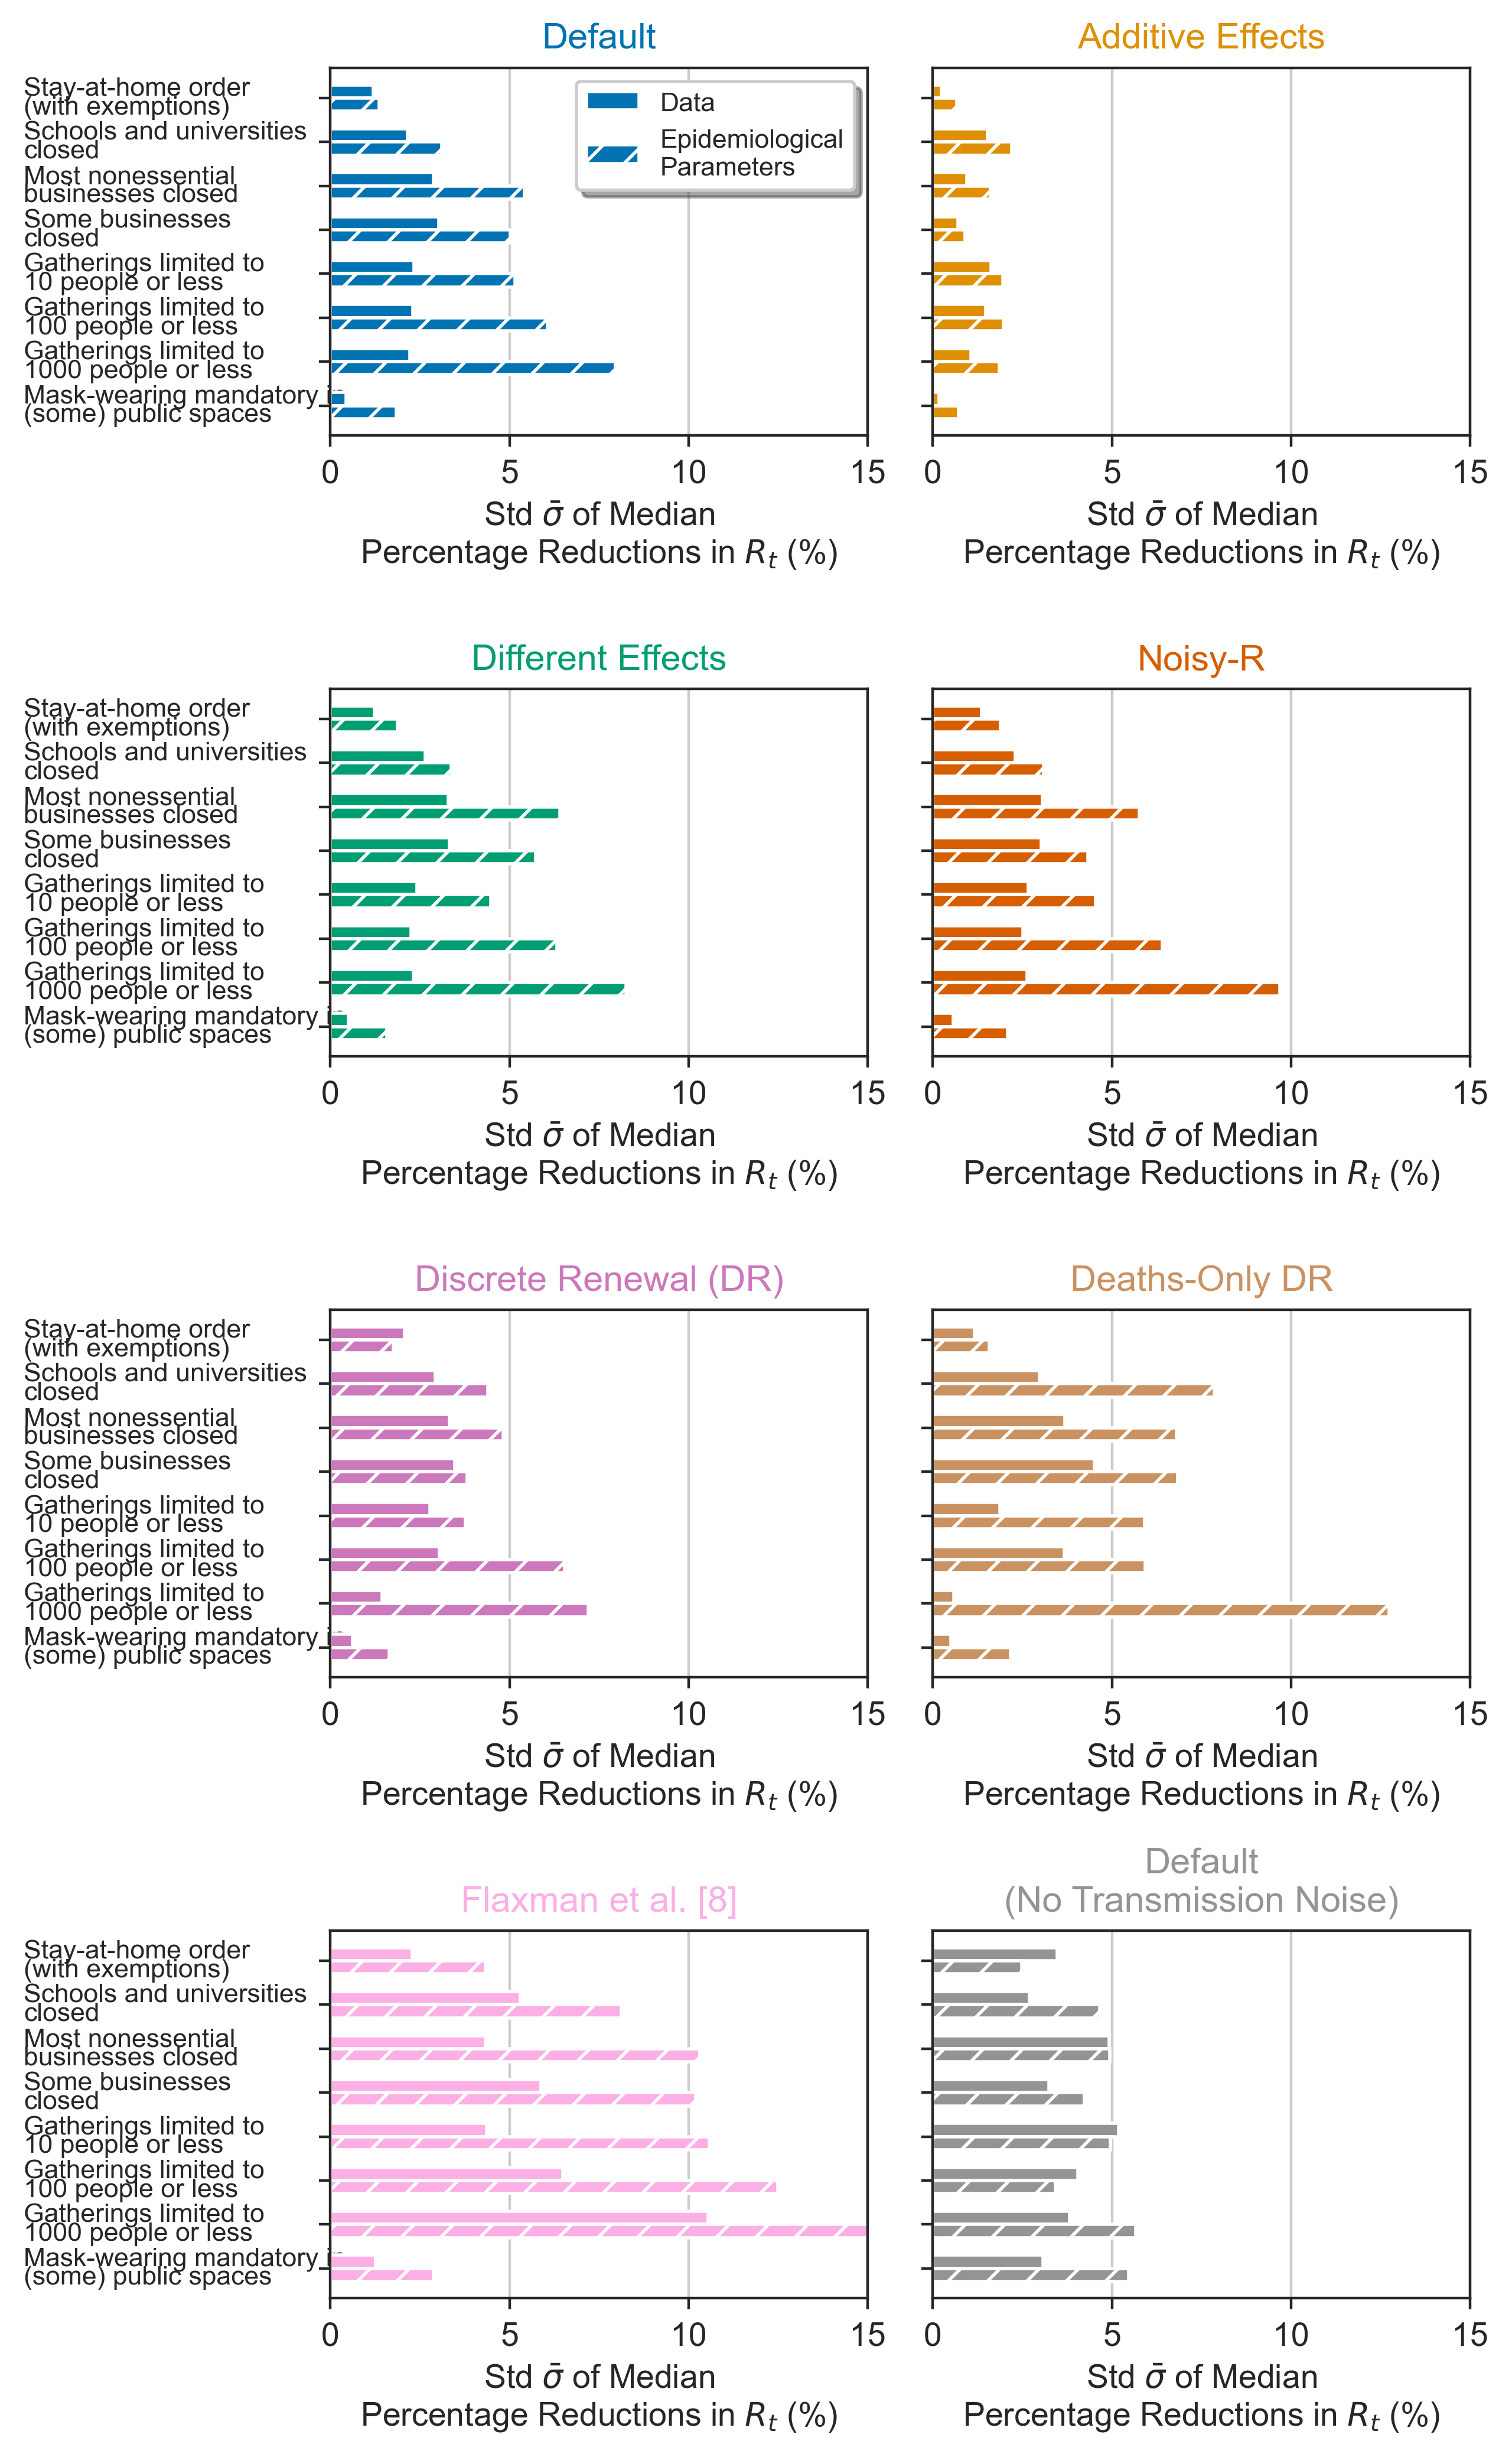

In [128]:
fig = plt.figure(figsize=(6.5, 10.5), dpi=400)

for m_i, (col, mdict, name, ddict, edict) in enumerate(zip(mcols, model_dicts, model_names, model_data_dicts, model_epi_dicts)):
    plt.subplot(4, 2, m_i+1)
    
    epi_score = model_dict_to_score(edict)
    data_score = model_dict_to_score(ddict)
    
    for i in range(8):
        if i == 0:
            plt.barh(i+0.15, data_score[i], align='center', height=0.3, color=col, label='Data')
            plt.barh(i-0.15, epi_score[i], align='center', height=0.3, color=col, hatch='//', label='Epidemiological\nParameters')
        else:
            plt.barh(i+0.15, data_score[i], align='center', height=0.3, color=col)
            plt.barh(i-0.15, epi_score[i], align='center', height=0.3, color=col, hatch='//')

    if m_i == 0:
        plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)
    
    if m_i % 2 == 0:
        plt.yticks(np.arange(8), cm_names, fontsize=8, ha='left', linespacing=0.7)
        yax = plt.gca().get_yaxis()
        yax.set_tick_params(pad=90)
    else:
        plt.yticks(np.arange(8), ["" for i in range(8)])
        
    plt.xlabel('Std $\\bar{\\sigma}$ of Median\nPercentage Reductions in $R_t$ (%)')

    plt.grid(b=None, which='major', axis='x')
    plt.title(name, fontsize=11, color=col)
    plt.xlim([0, 15])

plt.tight_layout()
plt.savefig('all_robustness.pdf', bbox_inches='tight')

In [ ]:
import pandas as pd

def categories_to_df(cats, loaded_dict):
    xs = []
    ys = []

    for c in cats:
        dt = loaded_dict[c]
        if dt is not None:
            nT, _ = dt.shape
            for t in range(nT):
                for cm in range(nCMs):
                    if not np.isnan(dt[t, cm]):
                        xs.append(dt[t, cm])
                        ys.append(derived_features[cm][0])

    df = pd.DataFrame.from_dict({'npi': ys, 'med': xs})
    return df

In [ ]:
plt.figure(figsize=(6.5, 3), dpi=300)
plt.subplot(121)

for i in range(len(model_types)):
    if i == 0:
        plt.barh(-i+0.15, -cases_ave_ll[i], align='center', height=0.3, color=mcols[i], label='Cases')
        plt.barh(-i-0.15, -deaths_ave_ll[i], align='center', height=0.3, color=mcols[i], hatch='//', label='Deaths')
    else:
        plt.barh(-i+0.15, -cases_ave_ll[i], align='center', height=0.3, color=mcols[i])
        plt.barh(-i-0.15, -deaths_ave_ll[i], align='center', height=0.3, color=mcols[i], hatch='//')

plt.yticks(-np.arange(len(model_types)), model_names, fontsize=10, ha='right')
plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)
plt.xlabel('Holdout Negative Log-Likelihood\nPer Day (lower is better)', fontsize=10)
plt.title('Holdout Performance', fontsize=11)
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5])
plt.xlim([5, 10.5])

plt.grid(b=None, which='major', axis='x')

plt.subplot(122)

for i in range(len(model_types)):
    if i == 0:
        plt.barh(-i+0.15, leaveout_scores[i], align='center', height=0.3, color=mcols[i], label='NPI Leave-out', edgecolor='black')
        plt.barh(-i-0.15, addin_scores[i], align='center', height=0.3, color=mcols[i], hatch='//', label='OxCGRT Add-in', edgecolor='black')
    else:
        plt.barh(-i+0.15, leaveout_scores[i], align='center', height=0.3, color=mcols[i], edgecolor='black')
        plt.barh(-i-0.15, addin_scores[i], align='center', height=0.3, color=mcols[i], hatch='//', edgecolor='black')

plt.yticks(-np.arange(len(model_types)), ["" for m in model_types], fontsize=10, ha='right')
plt.legend(fancybox=True, loc='upper right', fontsize=8, shadow=True)
plt.xlabel('Sensitivity Loss\n(lower is better)', fontsize=10)
plt.title('Sensitivity to Unobserved Factors', fontsize=11)
plt.xlim([0, 7])

plt.grid(b=None, which='major', axis='x')

plt.tight_layout()
plt.savefig('holdouts_uob.pdf', bbox_inches='tight')

yup additive


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


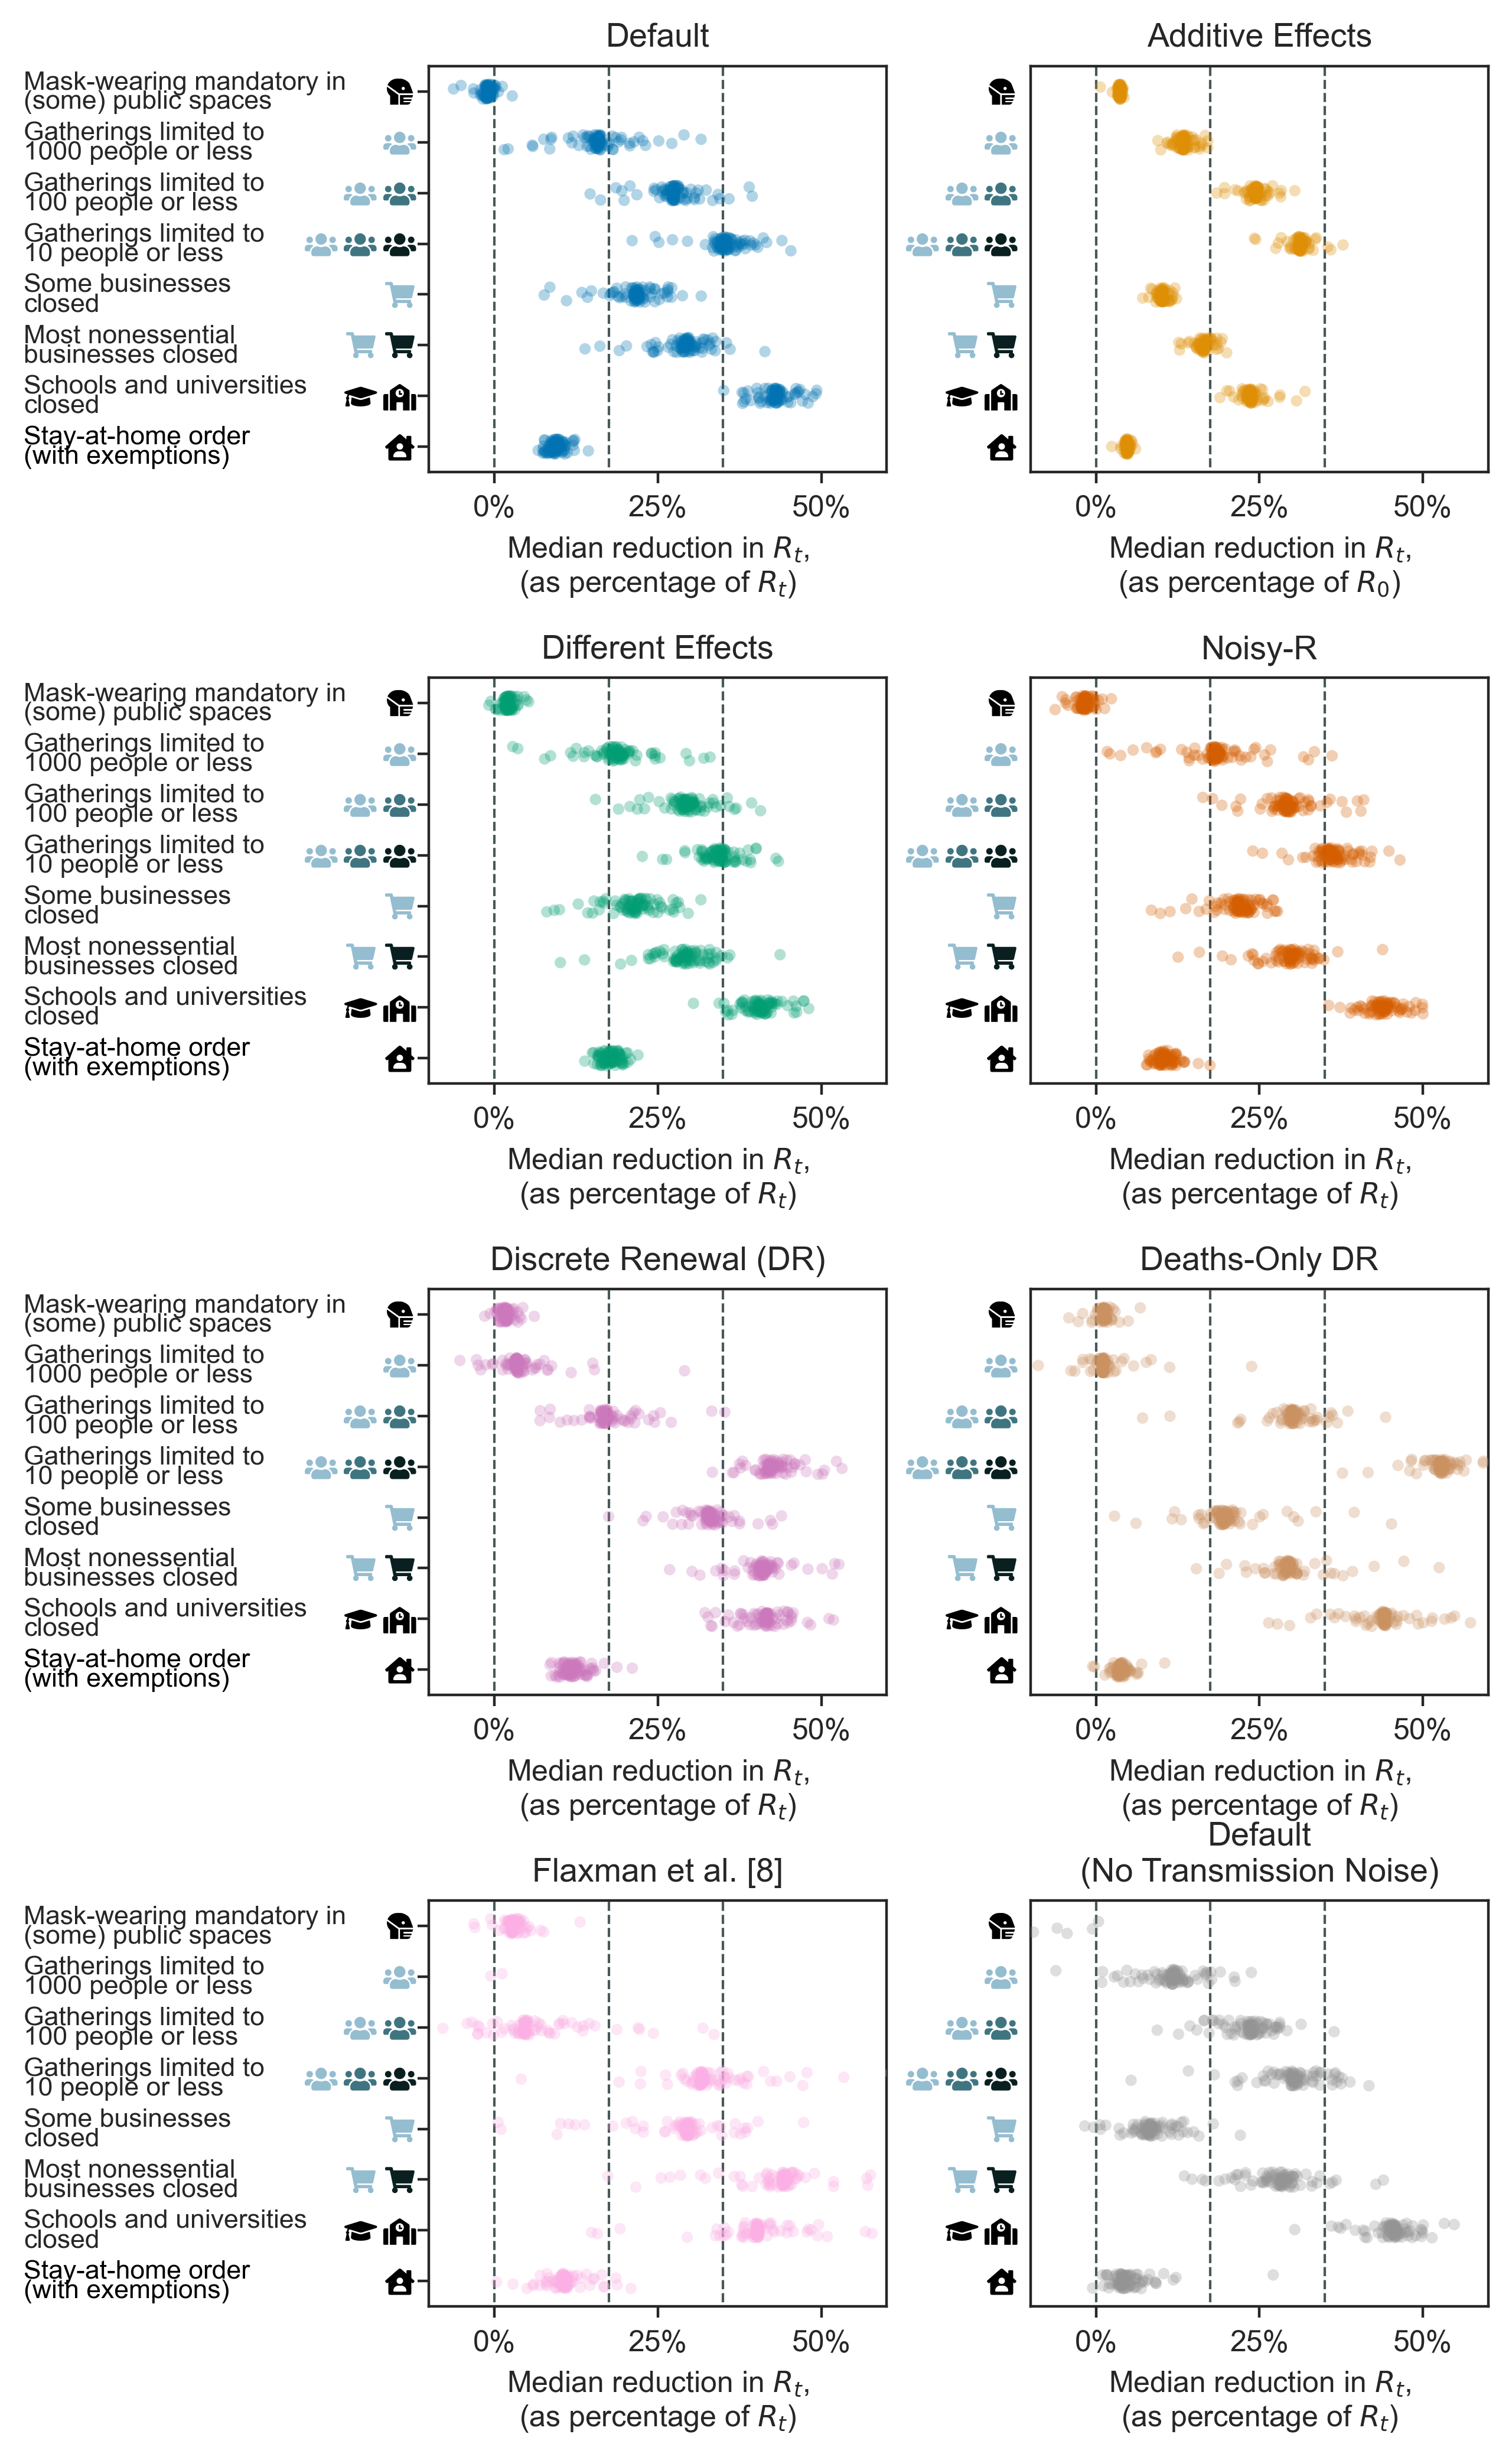

In [16]:
l=17.5
u=35
nCMs = 8

fig = plt.figure(figsize=(6.5, 10.5), dpi=400)

derived_features = derived_features_comb

def violin_plot(model_dict, color, yticks=True, ptype='swarm', additive=False):
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.75, zorder=-5, linewidth=0.75)

    data_m = categories_to_df(categories, model_dict)
    
    if ptype == 'violin':
        sns.violinplot(x="med", y="npi", data=data_m, color=color, inner=None, saturation=1, order=[l for l, _ in derived_features])
    elif ptype == 'swarm':
        sns.stripplot(x="med", y="npi", data=data_m, color=color, size=3.5, order=[l for l, _ in derived_features], alpha=0.3, jitter=0.15, linewidth=0)
#         sns.boxplot(x="med", y="npi", data=data_m, color=color, order=[l for l, _ in derived_features], saturation=1, whis=[2.5, 97.5], linewidth=0.75, fliersize=1)

    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 25, 50]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([7.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 4.5 - 6*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=col)

    ax = plt.gca()
    
    if yticks:
        plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left", linespacing=0.75)
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=120)
        
        for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
            if i < len(cm_plot_style):
                    col = cm_plot_style[i][1]
            else:
                col = "k"
        ticklabel.set_color(col)
    else:
        plt.yticks([])

    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    
    if not additive:
        plt.xlabel("Median reduction in $R_t$,\n(as percentage of $R_t$)", fontsize=9)
    else:
        print('yup additive')
        plt.xlabel("Median reduction in $R_t$,\n(as percentage of $R_0$)", fontsize=9)
    
    plt.ylabel(None)
    
    
for m_i, (col, mdict, name) in enumerate(zip(mcols, model_dicts, model_names)):
    plt.subplot(4, 2, m_i+1)
    
    if 'Additive' in name:
        additive = True
    else:
        additive = False
        
        
    if m_i in [0, 2, 4, 6]:
        violin_plot(mdict, col, additive=additive)
    else:
        violin_plot(mdict, col, False, additive=additive)
        
    plt.title(name, fontsize=10)
    
plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig('model_comparison.pdf', bbox_inches='tight')

In [17]:
data_m['npi'][2]

NameError: name 'data_m' is not defined

In [ ]:
npi_names = [l for l, _ in derived_features]

def categories_to_df_num(cats, loaded_dict):
    xs = []
    ys = []
    
    for c in cats:
        dt = loaded_dict[c]
        if dt is not None:
            nT, _ = dt.shape
            for t in range(nT):
                for cm in range(nCMs):
                    if not np.isnan(dt[t, cm]):
                        xs.append(dt[t, cm])
                        ys.append(npi_names.index(derived_features[cm][0]))

    df = pd.DataFrame.from_dict({'npi': ys, 'med': xs})
    return df

In [ ]:
l=25
u=50
nCMs = 8

fig = plt.figure(figsize=(6.5, 3.5), dpi=400)

derived_features = derived_features_comb

y_off = np.linspace(-0.3, 0.3, len(model_names))

for height in range(0, 10, 2):
        plt.fill_between([-100, 100], (height-0.5), (height+0.5), color="silver", alpha=0.5, linewidth=0)
    

for m_i, (col, mdict, name) in enumerate(zip(mcols, model_dicts, model_names)):
    
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)

    data_m = categories_to_df_num(categories, mdict)
    
    npis = data_m['npi']+y_off[m_i] + 0.03*np.random.normal(size=len(data_m['npi']))
    meds = data_m['med']
    
    
    plt.scatter(meds, npis, s=8, color=col, alpha=0.4, linewidth=0)
    
    plt.scatter(meds-np.inf, npis, s=8, color=col, linewidth=0, label=name)

#     sns.stripplot(x=meds, y=y, color=col, size=3.5, alpha=0.3, jitter=0.1, linewidth=0)

    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 25, 50]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([7.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 4.5 - 3.5*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=col)

    ax = plt.gca()
    

    plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
    yax = ax.get_yaxis()
    yax.set_tick_params(pad=130)

    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
    ticklabel.set_color(col)


    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    
    plt.xlabel("Median reduction in $R_t$", fontsize=9)
    
    plt.ylabel(None)
        
    
plt.legend(fancybox=True, loc='upper left', fontsize=8, shadow=True, ncol=1, bbox_to_anchor=(1.01, 1))
plt.tight_layout()

plt.savefig('model_combined.pdf', bbox_inches='tight')

# With Exclusions 

In [ ]:
model_names

In [ ]:
l=25
u=50
nCMs = 8

fig = plt.figure(figsize=(6.5, 3.3), dpi=400)

plt.subplot(121)
derived_features = derived_features_comb

y_off = np.linspace(-0.3, 0.3, len(model_names)-3)

for height in range(0, 10, 2):
        plt.fill_between([-100, 100], (height-0.5), (height+0.5), color="silver", alpha=0.5, linewidth=0)
    
['Default',
 'Additive Effects',
 'Different Effects',
 'Noisy-R',
 'Discrete Renewal (DR)',
 'Deaths-Only DR',
 'Flaxman et al. [8]',
 'Default\n(No Transmission Noise)']

p_i = 0

for m_i, (col, mdict, name) in enumerate(zip(mcols, model_dicts, model_names)):
    
    if name in ['Flaxman et al. [8]', 'Default\n(No Transmission Noise)']:
        continue
                
    
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)

    data_m = categories_to_df_num(categories, mdict)
         
    npis = data_m['npi']+y_off[p_i] + 0.03*np.random.normal(size=len(data_m['npi']))
    meds = data_m['med']
    
    
    if not name == 'Additive Effects':
        plt.scatter(meds, npis, s=8, color=col, alpha=0.4, linewidth=0)
        p_i += 1
    
    plt.scatter(meds-np.inf, npis, s=8, color=col, linewidth=0, label=name)

#     sns.stripplot(x=meds, y=y, color=col, size=3.5, alpha=0.3, jitter=0.1, linewidth=0)

    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 25, 50]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([7.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 4.5 - 5.5*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=col)

    ax = plt.gca()
    

    plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
    yax = ax.get_yaxis()
    yax.set_tick_params(pad=130)

    for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
        if i < len(cm_plot_style):
                col = cm_plot_style[i][1]
        else:
            col = "k"
    ticklabel.set_color(col)


    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    
    plt.xlabel("Median reduction in $R_t$\n(expressed in terms of $R_t$)", fontsize=9)
    
    plt.ylabel(None)
        
plt.title('Multiplicative Effects Models', fontsize=10)
# plt.legend(fancybox=True, loc='upper center', fontsize=8, shadow=True, ncol=3, bbox_to_anchor=(1.01, -0.25))

ax1 = plt.gca()

plt.subplot(122)
derived_features = derived_features_comb

y_off = np.linspace(-0.3, 0.3, len(model_names))

for height in range(0, 10, 2):
        plt.fill_between([-100, 100], (height-0.5), (height+0.5), color="silver", alpha=0.5, linewidth=0)
    

for m_i, (col, mdict, name) in enumerate(zip(mcols, model_dicts, model_names)):
    
    if not name == 'Additive Effects':
        continue
                
    
    plt.plot([0, 0], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([l, l], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)
    plt.plot([u, u], [-1, 10], color=cols[2], linestyle='--', alpha=0.5, zorder=-5, linewidth=0.75)

    data_m = categories_to_df_num(categories, mdict)
    
                
    npis = data_m['npi'] + 0.05*np.random.normal(size=len(data_m['npi']))
    meds = data_m['med']
    
    plt.scatter(meds, npis, s=12, color=col, alpha=0.4, linewidth=0)
    
    x_min = -10
    x_max = 60
    plt.xlim([x_min, x_max])
    xtick_vals = [0, 25, 50]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([7.5, -0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nCMs):
        for i, val in enumerate(derived_features[cm][1]):
            if val < len(cm_plot_style):
                col = cm_plot_style[val][1]
            else:
                col = "k"
            plt.text(x_min - 4.5 - 5.5*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=col)

    ax = plt.gca()
    

    plt.yticks(np.arange(nCMs), [f"" for f in derived_features], fontsize=8, ha="left")
    yax = ax.get_yaxis()
    yax.set_tick_params(pad=130)


    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    
    plt.xlabel("Median reduction in $R_t$\n(expressed in terms of $R_0$)", fontsize=9)
    
    plt.ylabel(None)
        
plt.title('Additive Effects Model', fontsize=10)
plt.tight_layout(w_pad = 0)
ax1.legend(fancybox=True, loc='upper center', fontsize=8, shadow=True, ncol=3, bbox_to_anchor=(1.125, -0.3))

plt.savefig('model_combined_transmission.pdf', bbox_inches='tight')

In [ ]:
for m in model_types:
    traces = load_tagged_traces('../../server_neurips2/', m, 'region_holdout')
    print(m)
    print(np.median(traces[0][0], axis=0))

In [ ]:
for m_i, mdict in enumerate(model_dicts):
    print(model_names[m_i])
    for k, v in mdict.items():
        if v is not None:
            print(f'  {k}:')
            print(f'       {np.mean(v, axis=0)}')